In [42]:
import sys
sys.path.append('..')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import logging
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.io import read

from m_ff.configurations import carve_confs
from m_ff.models import TwoBodySingleSpeciesModel, ThreeBodySingleSpeciesModel, CombinedSingleSpeciesModel

logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [32]:
# Parameters
directory = Path('data/BIP_300/')
r_cut = 8.5
sigma_2b = 0.3
sigma_3b = 1.2
noise = 0.0001

# GP Parameters
ntr = 5
ntest = 10

# mapping
grid_start = 1.5
num_2b = 20
num_3b = 10

## Configurations

In [14]:
# # ----------------------------------------
# # Construct a configuration database
# # ----------------------------------------


n_data = 500

filename = directory / 'movie.xyz'

traj = read(filename, index=slice(None), format='extxyz')

elements, confs, forces, energies = carve_confs(
    traj, r_cut, n_data,
    forces_label='force', energy_label='energy')

if not os.path.exists(directory):
    os.makedirs(directory)

np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)
np.save('{}/energies_cut={:.2f}.npy'.format(directory, r_cut), energies)

lens = [len(conf) for conf in confs]

logging.info('\n'.join((
    'Number of atoms in a configuration:',
    '   maximum: {}'.format(np.max(lens)),
    '   minimum: {}'.format(np.min(lens)),
    '   average: {:.4}'.format(np.mean(lens))
)))

In [33]:
# Get configurations and forces from file
confs = np.load(directory / 'confs_cut={:.2f}.npy'.format(r_cut))
forces = np.load(directory / 'forces_cut={:.2f}.npy'.format(r_cut))
numconfs = len(forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

# Separate into random testing and training dataset
# tr_confs, tr_forces = confs[ind[:ntr]], forces[ind[:ntr]]
# tst_confs, tst_forces = confs[ind[ntr:]], forces[ind[ntr:]]

# Use fixed training and testing dataset
tr_confs, tr_forces = confs[:ntr], forces[:ntr]
tst_confs, tst_forces = confs[-ntest - 1:-1], forces[-ntest - 1:-1]

## GP - 2+3 body

In [34]:
model_c = CombinedSingleSpeciesModel(elements[0], r_cut, sigma_2b, sigma_3b, r_cut / 10.0, r_cut / 10.0, noise)
# model_c = ThreeBodySingleSpeciesModel(elements[0], r_cut, sigma_3b, r_cut / 10.0, noise)
# model_c = TwoBodySingleSpeciesModel(elementslist[0], r_cut, sigma_2b, r_cut / 10.0, noise)

In [35]:
model_c.fit(tr_confs, tr_forces)

In [36]:
# Test the GP performance
print('Testing GP')

gp_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))

for i in np.arange(ntest):
    gp_forces[i, :] = model_c.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_forces[i, :] - tst_forces[i, :]

MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

Testing GP
MAEF on forces: 1.7521 +- 0.7724
Relative MAEF on forces: 3.4428 +- 1.5178


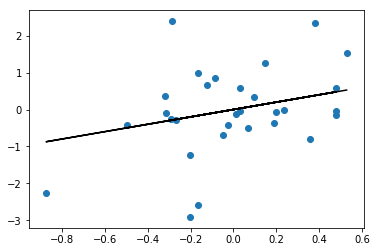

In [37]:
plt.scatter(tst_forces, gp_forces)
plt.plot(tst_forces, tst_forces, 'k-')
plt.show()

## Mapping

In [38]:
def rmse(x1, x2):
    rms = np.sqrt(np.sum(np.square(x1 - x2), axis=1))
    return np.mean(rms), np.std(rms)

In [39]:
model_c.build_grid(grid_start, num_2b, num_3b)
# model_c.build_grid(grid_start, num_2b)

In [40]:
model_c.save_grid("Ni_19_example.npy")

Saved 2- and 3-body grids with name: Ni_19_example.npy


In [ ]:
model_2 = CombinedSingleSpeciesModel(elements[0], r_cut, sigma_2b, sigma_3b, r_cut / 10.0, r_cut / 10.0, noise)
model_2.load_grid("Ni_19_example.npy")

## Test mapping on traj

In [91]:
from m_ff.calculators import TwoBodySingleSpecies, ThreeBodySingleSpecies, CombinedSingleSpecies
# calc = CombinedSingleSpecies(r_cut, model_c.grid[(26, 26)], model_c.grid[(26, 26, 26)], rep_alpha = 1.5)
calc = TwoBodySingleSpecies(r_cut, model_c.grid[(28, 28)], rep_alpha = 1.5)
# calc = ThreeBodySingleSpecies(r_cut, model_c.grid[(28, 28, 28)])

filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0, 10))
for atoms in traj:
    atoms.set_cell(21.0*np.identity(3))
    atoms.set_calculator(calc)

    #rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
    #print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))
    print(atoms.get_forces())


INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


[[ 8.27198960e-02  1.13173914e-01  2.58682861e-02]
 [ 3.67478400e-02  1.92470073e-02 -4.23579135e-02]
 [ 1.07914811e-01 -7.65118373e-02 -1.65831749e-02]
 [ 1.53304231e-03  2.20259168e-02  4.51428894e-02]
 [-1.65650655e-02  5.65446192e-03 -8.88816426e-03]
 [-7.62826724e-04 -4.34198091e-02  3.43999889e-02]
 [-1.09815242e-01  7.84419434e-02  1.50610890e-02]
 [-2.70525919e-02 -8.86369254e-04 -3.57364458e-02]
 [-8.62383493e-02 -1.11826265e-01 -2.79171203e-02]
 [ 4.89697347e-02  2.01743323e-03 -1.82876146e-02]
 [ 4.14202626e-02  2.52921535e-02 -1.40019405e-02]
 [-3.27651962e-02 -1.42603209e-02 -1.99475462e-02]
 [-4.38488631e-02  2.10752897e-03 -1.75565127e-02]
 [ 9.41114115e-06  2.84475916e-02 -1.29947768e-01]
 [-1.73912979e-02  4.53413277e-02  3.27663672e-02]
 [-1.07088869e-02 -5.40490702e-02  1.10147520e-02]
 [ 8.35382016e-03  3.68181776e-02  2.72143823e-02]
 [ 1.93001258e-02 -4.89449428e-02  9.51055498e-03]
 [-1.82062447e-03 -2.86688412e-02  1.30245891e-01]]
[[ 0.05634748  0.03846606  0.0

## Run simple dynamics

In [92]:
# Global Variables Definition
gamma = 0.001
temp = 300 #K
dt = 3.0  # fs
steps = 1000
t = steps * dt * 10 ** (-3)  # time in ps

In [93]:
atoms = traj[4]
atoms.set_pbc(False)
atoms.set_cell([(21, 0, 0), (0, 21, 0), (0, 0, 21)])
atoms.set_calculator(calc)

In [94]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.velocitydistribution import Stationary
from ase.md.velocitydistribution import ZeroRotation
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase import units

Stationary(atoms)
ZeroRotation(atoms)
dyn = VelocityVerlet(atoms, dt * units.fs)
MaxwellBoltzmannDistribution(atoms, temp * units.kB)

In [95]:
def printenergy(a=atoms):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    
def printforces(a=atoms):
    forces = a.get_forces()
    print(forces)

In [96]:
import scipy as sp
pos = atoms.get_positions()
dist = np.reshape(sp.spatial.distance.cdist(pos, pos), len(pos)**2)


In [ ]:
printenergy(atoms)
for i in range(100):
    dyn.run(100)
    printenergy(atoms)


Energy per atom: Epot = -0.722eV  Ekin = 0.039eV (T=300K)  Etot = -0.683eV
Energy per atom: Epot = -0.710eV  Ekin = 0.026eV (T=203K)  Etot = -0.684eV
Energy per atom: Epot = -0.713eV  Ekin = 0.029eV (T=228K)  Etot = -0.684eV
Energy per atom: Epot = -0.718eV  Ekin = 0.033eV (T=257K)  Etot = -0.685eV
Energy per atom: Epot = -0.718eV  Ekin = 0.034eV (T=265K)  Etot = -0.684eV
Energy per atom: Epot = -0.713eV  Ekin = 0.029eV (T=227K)  Etot = -0.684eV
Energy per atom: Epot = -0.712eV  Ekin = 0.027eV (T=211K)  Etot = -0.684eV
Energy per atom: Epot = -0.716eV  Ekin = 0.032eV (T=250K)  Etot = -0.684eV
Energy per atom: Epot = -0.718eV  Ekin = 0.034eV (T=263K)  Etot = -0.684eV
Energy per atom: Epot = -0.721eV  Ekin = 0.037eV (T=287K)  Etot = -0.684eV
Energy per atom: Epot = -0.706eV  Ekin = 0.023eV (T=177K)  Etot = -0.683eV
Energy per atom: Epot = -0.715eV  Ekin = 0.031eV (T=238K)  Etot = -0.685eV
Energy per atom: Epot = -0.716eV  Ekin = 0.033eV (T=254K)  Etot = -0.683eV
Energy per atom: Epot = -

## EAM Testing

In [16]:
from ase.calculators.eam import EAM

from ase.build import bulk

# test to generate an EAM potential file using a simplified
# approximation to the Mishin potential Al99.eam.alloy data

from scipy.interpolate import InterpolatedUnivariateSpline as spline

cutoff = 10.0

n = 21
rs = np.arange(0, n) * (cutoff / n)
rhos = np.arange(0, 2, 2. / n)

# generated from
# mishin = EAM(potential='../potentials/Al99.eam.alloy')
# m_density = mishin.electron_density[0](rs)
# m_embedded = mishin.embedded_energy[0](rhos)
# m_phi = mishin.phi[0,0](rs)

m_density = np.array([2.78589606e-01, 2.02694937e-01, 1.45334053e-01,
                      1.06069912e-01, 8.42517168e-02, 7.65140344e-02,
                      7.76263116e-02, 8.23214224e-02, 8.53322309e-02,
                      8.13915861e-02, 6.59095390e-02, 4.28915711e-02,
                      2.27910928e-02, 1.13713167e-02, 6.05020311e-03,
                      3.65836583e-03, 2.60587564e-03, 2.06750708e-03,
                      1.48749693e-03, 7.40019174e-04, 6.21225205e-05])

m_embedded = np.array([1.04222211e-10, -1.04142633e+00, -1.60359806e+00,
                       -1.89287637e+00, -2.09490167e+00, -2.26456628e+00,
                       -2.40590322e+00, -2.52245359e+00, -2.61385603e+00,
                       -2.67744693e+00, -2.71053295e+00, -2.71110418e+00,
                       -2.69287013e+00, -2.68464527e+00, -2.69204083e+00,
                       -2.68976209e+00, -2.66001244e+00, -2.60122024e+00,
                       -2.51338548e+00, -2.39650817e+00, -2.25058831e+00])

m_phi = np.array([6.27032242e+01, 3.49638589e+01, 1.79007014e+01,
                  8.69001383e+00, 4.51545250e+00, 2.83260884e+00,
                  1.93216616e+00, 1.06795515e+00, 3.37740836e-01,
                  1.61087890e-02, -6.20816372e-02, -6.51314297e-02,
                  -5.35210341e-02, -5.20950200e-02, -5.51709524e-02,
                  -4.89093894e-02, -3.28051688e-02, -1.13738785e-02,
                  2.33833655e-03, 4.19132033e-03, 1.68600692e-04])

m_densityf = spline(rs, m_density)
m_embeddedf = spline(rhos, m_embedded)
m_phif = spline(rs, m_phi)

mishin_approx = EAM(elements=['Ni'], embedded_energy=np.array([m_embeddedf]),
                    electron_density=np.array([m_densityf]),
                    phi=np.array([[m_phif]]), cutoff=cutoff, form='alloy',
                    # the following terms are only required to write out a file
                    Z=[13], nr=n, nrho=n, dr=cutoff / n, drho=2. / n,
                    lattice=['fcc'], mass=[58.692], a=[2.58])

atoms.set_calculator(calc)

In [48]:
dyn.run(steps)

## Pairwise potential test

In [50]:
model_2b = TwoBodySingleSpeciesModel(elementslist[0], r_cut, sigma_2b, r_cut / 10.0, noise)
model_2b.fit(tr_confs, tr_forces)

INFO:m_ff.kernels.twobody:Started compilation of theano two body single species kernels
INFO:m_ff.kernels.twobody:Ended compilation of theano two body single species kernels


In [51]:
# Test the GP performance
print('Testing GP')

gp_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))

for i in np.arange(ntest):
    gp_forces[i, :] = model_2b.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_forces[i, :] - tst_forces[i, :]

MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

Testing GP
MAEF on forces: 0.1404 +- 0.0750
Relative MAEF on forces: 0.1943 +- 0.1038


In [52]:
grid_2b = model_2b.build_grid(grid_start, num_2b)


In [53]:
calc = TwoBodySingleSpecies(r_cut, grid_c_2b)
atoms.set_calculator(calc)

In [54]:
dyn.run(steps)

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize
